In [1]:
import numpy as np
import loompy
import scvelo as scv
import velocyto as vcy
import pandas as pd 
import scanpy as sc
import cellrank as cr
import matplotlib.pyplot as plt
import os

def Pre_process(filename,mode = None,n_jobs = 80):
    
    # read spliced/unspliced files from 
    spliced = np.array(pd.read_csv(filename + '.spliced.txt',sep='\t',index_col=0))
    unspliced = np.array(pd.read_csv(filename + '.unspliced.txt', sep='\t',index_col=0))
    ambiguous = np.array(pd.read_csv(filename + '.ambigous.txt',sep='\t',index_col=0))

    cells = pd.read_csv(filename + '.celltype.csv')
    cellid = np.array(cells.barcode)
    seurat_clusters = np.array(cells.Cell_Type)
    genes = pd.read_csv(filename+ '.genes.csv')
    genes = np.array(genes.x)

    ## 创建loom文件
    col_attr = {"CellID": cellid}
    row_attr = {"Gene": genes}
    loompy.create(filename + '_new.cells.loom', spliced,row_attr,col_attr)
    lm = loompy.connect(filename +'_new.cells.loom')
    lm['spliced'] = spliced
    lm['unspliced'] = unspliced
    lm['ambiguous'] = ambiguous
    lm.ca['clusters'] = seurat_clusters
    lm.close()

    ## scvelo分析
    adata = scv.read_loom(filename + '_new.cells.loom')
    scv.pp.filter_and_normalize(adata,min_shared_counts=20, n_top_genes=2000)

    scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # Computes moments for velocity estimation.
    scv.pp.remove_duplicate_cells(adata)
    scv.pp.neighbors(adata)

    if mode == "dynamical":
        scv.tl.recover_dynamics(adata,n_jobs = n_jobs)
        scv.tl.velocity(adata, mode='dynamical')
        scv.tl.velocity_graph(adata)
    else:
        scv.tl.velocity(adata)
        scv.tl.velocity_graph(adata)
    
    ## 添加umap坐标信息
    umap = pd.read_csv(filename + '.umap.csv',sep=',',index_col=0)
    adata.obsm['X_umap'] = np.vstack((umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    return adata

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
root_dir  = "/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/"
filenames = [os.path.join(root_dir,f,f.replace("_loom","")) for f in os.listdir(root_dir)]
filenames

['/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Neoblast.combined_loom/Neoblast.combined',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Female_GSCs_loom/Female_GSCs',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Male_GSCs_loom/Male_GSCs',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Male_seob_neuron_loom/Male_seob_neuron',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Female_seob_neuron_loom/Female_seob_neuron',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/vf1_cells_loom/vf1_cells',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Nanos1_cells_loom/Nanos1_cells',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Neoblast.combined_1126_loom/Neoblast.combined_1126']

In [3]:
filename = filenames[-1]
spliced = np.array(pd.read_csv(filename + '.spliced.txt',sep='\t',index_col=0))
unspliced = np.array(pd.read_csv(filename + '.unspliced.txt', sep='\t',index_col=0))
ambiguous = np.array(pd.read_csv(filename + '.ambigous.txt',sep='\t',index_col=0))

cells = pd.read_csv(filename + '.celltype.csv')
cellid = np.array(cells.barcode)
seurat_clusters = np.array(cells.Cell_Type)
genes = pd.read_csv(filename+ '.genes.csv')
genes = np.array(genes.x)

## 创建loom文件
col_attr = {"CellID": cellid}
row_attr = {"Gene": genes}
loompy.create(filename + '_new.cells.loom', spliced,row_attr,col_attr)
lm = loompy.connect(filename +'_new.cells.loom')
lm['spliced'] = spliced
lm['unspliced'] = unspliced
lm['ambiguous'] = ambiguous
lm.ca['clusters'] = seurat_clusters
lm.close()

In [4]:
# read spliced/unspliced files from 

## scvelo分析
adata = scv.read_loom(filename + '_new.cells.loom')
scv.pp.filter_and_normalize(adata,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # Computes moments for velocity estimation.
scv.pp.remove_duplicate_cells(adata)
scv.pp.neighbors(adata)

Filtered out 1701 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:26) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [5]:
## 添加umap坐标信息
umap = pd.read_csv(filename + '.umap.csv',sep=',',index_col=0)
adata.obsm['X_umap'] = np.vstack((umap['UMAP_1'].values, umap['UMAP_2'].values)).T

In [6]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/19838 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:01:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [7]:
adata.obs["clusters"].cat.set_categories(['SSCs-alpha',
                                           'SSCs-beta',
                                          #'SSCs-beta 2',
                                           'SSCs-gamma 1',
                                           'SSCs-gamma 2',
                                           'SSCs-delta',
                                           'SSCs-epsilon',
                                           'SSCs-kappa',
                                           #'SSCs-mu',
                                           'SSCs-nu',
                                           'GSCs',
                                           'GSC progeny',
                                           'Female gametophyte',
                                           'Male gametophyte',
                                           'S1',
                                           'S1 progeny',
                                           'Early Vo',
                                           'Late Vo',
                                           #'Mature Vo',
                                           'Mehlis gland'], ordered=True, inplace=True)                                                         

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ../../02.figures/Analysis_20241126/Fig.png


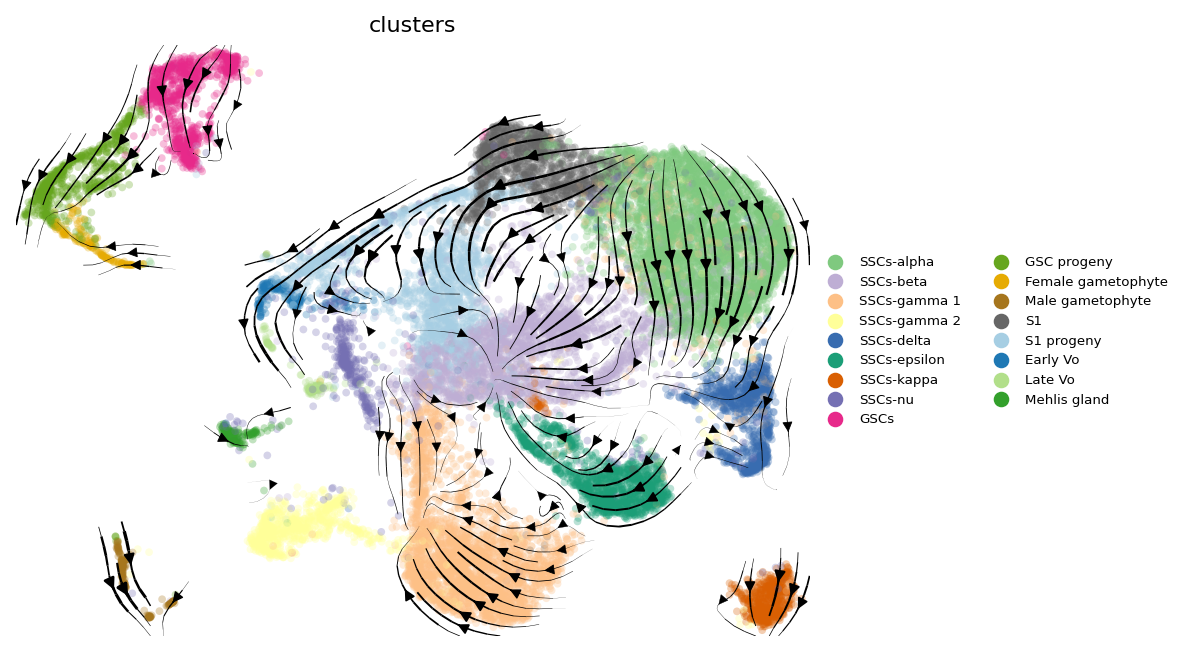

In [10]:
scv.pl.velocity_embedding_stream(adata, basis='umap',dpi=160,linewidth=0.8,legend_fontsize='6',colorbar=True,
                                 palette=cb_palette ,legend_loc='right margin',save='../../02.figures/Analysis_20241126/Fig.pdf')

In [43]:
#adata.write_h5ad("../../04.velocity/Neoblast.combined_loom/Neoblast.combined.h5ad")

In [9]:
cb_palette = ["#7FC97F", "#BEAED4", "#FDC086", "#FFFF99" ,"#386CB0" ,"#1B9E77", "#D95F02", "#7570B3" ,"#E7298A",
             "#66A61E", "#E6AB02" ,"#A6761D" ,"#666666", "#A6CEE3","#1F78B4", "#B2DF8A" ,"#33A02C"] #"#FB9A99"


# run with stochastic mode

In [26]:
adata[[x for x in adata.obs.index.to_list() if "F" in x]]

View of AnnData object with n_obs × n_vars = 11413 × 2000
    obs: 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'clusters_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:837: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


saving figure to file ../../02.figures/Analysis_20241126/Fig2B_a.png


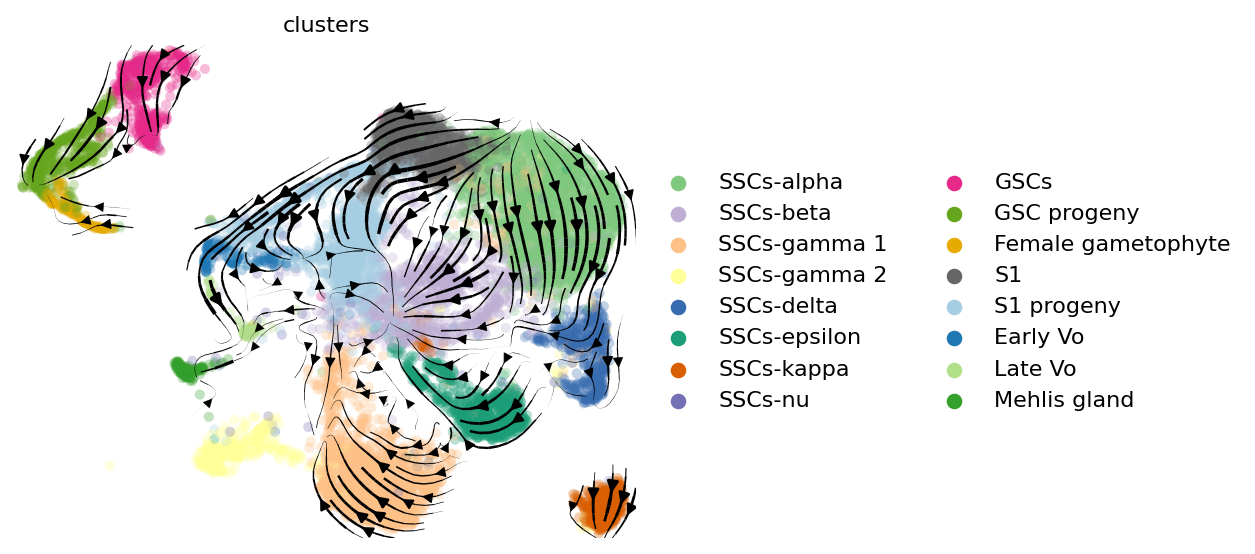

In [11]:
cb_palette = ["#7FC97F", "#BEAED4", "#FDC086", "#FFFF99" ,"#386CB0" ,"#1B9E77", "#D95F02", "#7570B3" ,"#E7298A",
             "#66A61E", "#E6AB02" ,"#666666", "#A6CEE3","#1F78B4", "#B2DF8A" ,"#33A02C"] #"#FB9A99" "#A6761D" ,


scv.pl.velocity_embedding_stream(adata[[x for x in adata.obs.index.to_list() if "F" in x]],
                                 palette=cb_palette,
                                 basis='umap',
                                 legend_loc='right margin',xlabel='umap1',
                                 ylabel='umap2',dpi=160,save="../../02.figures/Analysis_20241126/Fig2B_a.png",figsize=[5,4])

In [24]:
adata.obs.index.to_list()

['18dpi_F_AAACCCAAGGCATCTT-1',
 '18dpi_F_AAACCCAAGTGTGTTC-1',
 '18dpi_F_AAACCCAGTCTTGAAC-1',
 '18dpi_F_AAACCCATCCTAACAG-1',
 '18dpi_F_AAACGAATCAGTGTGT-1',
 '18dpi_F_AAACGAATCATCGCAA-1',
 '18dpi_F_AAACGCTCAAGCGATG-1',
 '18dpi_F_AAACGCTTCTACCTTA-1',
 '18dpi_F_AAAGAACCATGACCCG-1',
 '18dpi_F_AAAGAACCATTGCTGA-1',
 '18dpi_F_AAAGAACGTGGTCCGT-1',
 '18dpi_F_AAAGGATCAAATGATG-1',
 '18dpi_F_AAAGGATCAGCGTATT-1',
 '18dpi_F_AAAGGATGTCGTGTTA-1',
 '18dpi_F_AAAGGGCAGGTGCCTC-1',
 '18dpi_F_AAAGGGCCAGCCTACG-1',
 '18dpi_F_AAAGGTAAGGAATCGC-1',
 '18dpi_F_AAAGGTACACCTCTAC-1',
 '18dpi_F_AAAGTCCCACAGTGTT-1',
 '18dpi_F_AAAGTCCCAGCGAGTA-1',
 '18dpi_F_AAAGTCCGTACACGCC-1',
 '18dpi_F_AAAGTCCTCACCTGGG-1',
 '18dpi_F_AAAGTGACACACAGCC-1',
 '18dpi_F_AAAGTGAGTAAGGCCA-1',
 '18dpi_F_AAAGTGAGTCTTGTCC-1',
 '18dpi_F_AAATGGAAGCGGTAGT-1',
 '18dpi_F_AAATGGACAGCACAAG-1',
 '18dpi_F_AAATGGACAGTATACC-1',
 '18dpi_F_AAATGGATCATTGAGC-1',
 '18dpi_F_AACAACCCAGAGTCAG-1',
 '18dpi_F_AACAACCTCAACCTCC-1',
 '18dpi_F_AACAAGAAGATGGTAT-1',
 '18dpi_

19682

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:837: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


saving figure to file ../../02.figures/Analysis_20241126/Fig2B_b.png


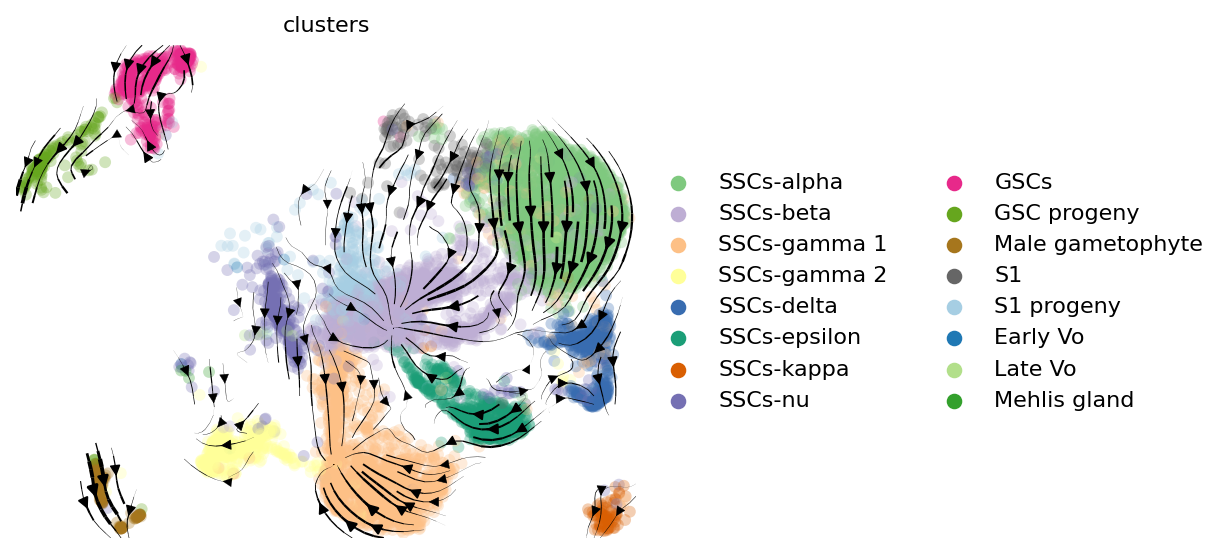

In [42]:
cb_palette = ["#7FC97F", "#BEAED4", "#FDC086", "#FFFF99" ,"#386CB0" ,"#1B9E77", "#D95F02", "#7570B3" ,"#E7298A",
             "#66A61E", "#A6761D" ,"#666666", "#A6CEE3","#1F78B4", "#B2DF8A" ,"#33A02C"] #"#FB9A99" "#E6AB02" ,
scv.pl.velocity_embedding_stream(adata[(adata.obs_names.str.contains("M")) & (adata.obs['clusters'] != 'Female gametophyte')],palette=cb_palette,
                                 basis='umap',legend_loc='right margin',xlabel='umap1',ylabel='umap2',dpi=160,
                                 save="../../02.figures/Analysis_20241126/Fig2B_b.png",figsize=[5,4])

# GSCs

In [16]:
adata_gscs_f = Pre_process(filenames[1])
adata_gscs_m = Pre_process(filenames[2])

Filtered out 3258 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/1230 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py3.9/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 3151 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/749 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/shycheng/miniconda3/envs/py3.9/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


In [17]:
adata_gscs_f.obs["clusters"].cat.set_categories([ 'GSCs','GSC progeny','Female gametophyte'], ordered=True, inplace=True)
adata_gscs_m.obs["clusters"].cat.set_categories([ 'GSCs','GSC progeny','Male gametophyte'], ordered=True, inplace=True)

saving figure to file ../../02.figures/Fig3/Fig3C_a.png


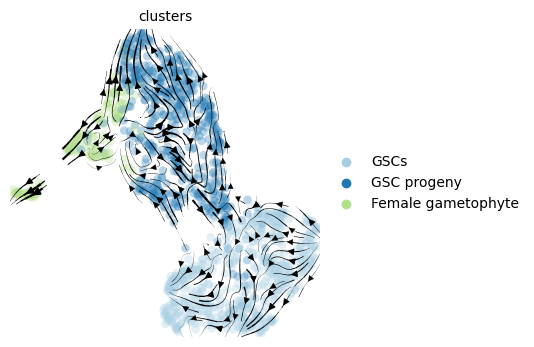

In [53]:
scv.pl.velocity_embedding_stream(adata_gscs_f, basis='umap',
                                 legend_loc='right margin',size=150,
                                 xlabel='umap1',ylabel='umap2',dpi=100,figsize=[4,4],
                                 palette=[cb_palette[x] for x in [13,14,15]],save="../../02.figures/Fig3/Fig3C_a.png")

In [2]:
from PIL import Image

# Open the image
img = Image.open("../../02.figures/Fig3/Fig3C_a.png")

# Rotate the image by 90 degrees counterclockwise
rotated_img = img.rotate(-90)

# Display the rotated image
rotated_img.show()

# Save the rotated image
rotated_img.save("../../02.figures/Figures_20241010/Fig3C_a.png")


(eog:363951): GLib-GIO-CRITICAL **: 16:04:31.533: g_dbus_proxy_new_sync: assertion 'G_IS_DBUS_CONNECTION (connection)' failed

(eog:363951): dconf-WARNING **: 16:04:31.597: failed to commit changes to dconf: Could not connect: Connection refused

(eog:363951): dconf-WARNING **: 16:04:31.597: failed to commit changes to dconf: Could not connect: Connection refused


saving figure to file ../../02.figures/Fig3/Fig3C_b.png


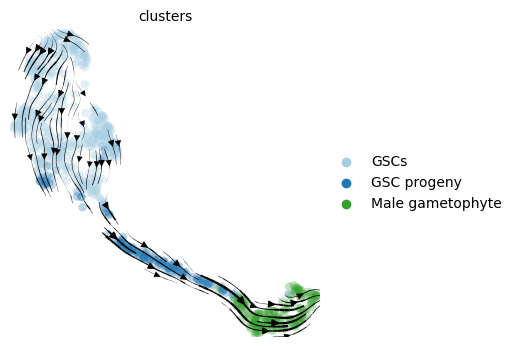

In [54]:
scv.pl.velocity_embedding_stream(adata_gscs_m, 
                                 basis='umap',size=150,
                                 legend_loc='right margin',
                                 xlabel='umap1',ylabel='umap2',
                                 dpi=100,save="../../02.figures/Fig3/Fig3C_b.png",
                                 palette=[cb_palette[x] for x in [13,14,16]],figsize=[4,4])

# if using dynamic model

recovering dynamics (using 20/256 cores)


  0%|          | 0/583 [00:00<?, ?gene/s]

/home/shycheng/miniconda3/envs/py3.9/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/shycheng/miniconda3/envs/py3.9/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/1230 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py3.9/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


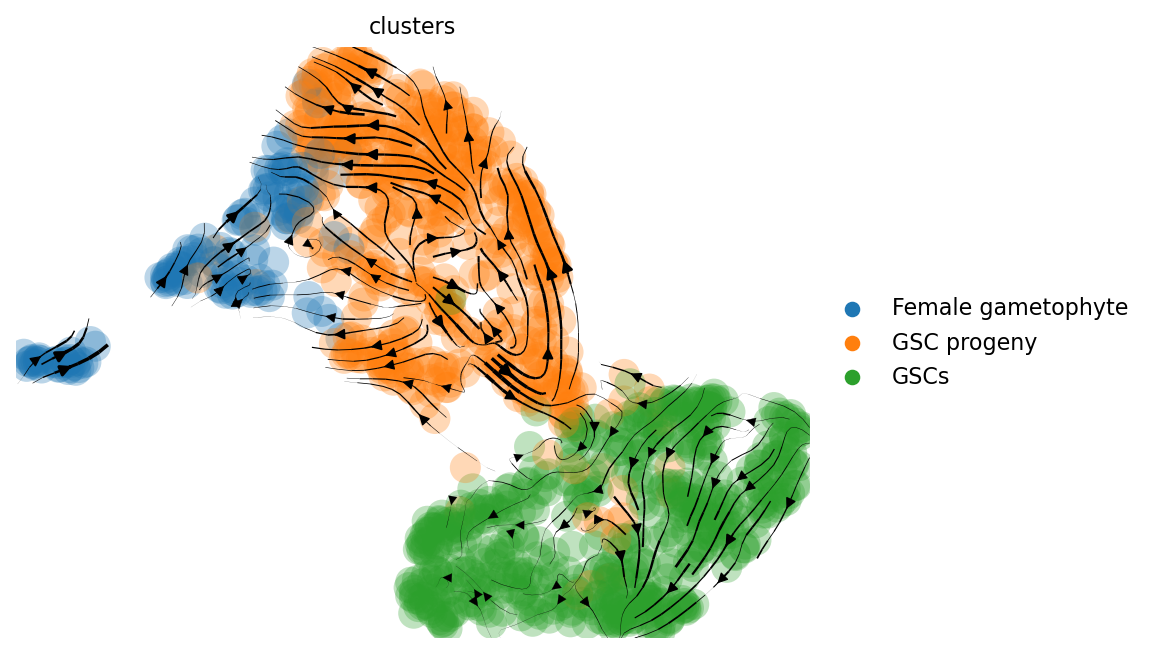

In [15]:
scv.tl.recover_dynamics(adata_gscs_f,n_jobs = 20)
scv.tl.velocity(adata_gscs_f, mode='dynamical')
scv.tl.velocity_graph(adata_gscs_f)
scv.pl.velocity_embedding_stream(adata_gscs_f, basis='umap',legend_loc='right margin',xlabel='umap1',ylabel='umap2',dpi=160)

In [ ]:
scv.tl.recover_dynamics(adata_gscs_f,n_jobs = 20)
scv.tl.velocity(adata_gscs_f, mode='dynamical')
scv.tl.velocity_graph(adata_gscs_f)
scv.pl.velocity_embedding_stream(adata_gscs_f, basis='umap',legend_loc='right margin',xlabel='umap1',ylabel='umap2',dpi=160)